In [1]:
# @title Imports {display-mode: "form"}
%matplotlib inline
import dask
import dask.dataframe as dd
import warnings
import logging
import plotly.express as px

from dask.distributed import Client

_ = dask.config.set(scheduler="threads")

In [2]:
client = Client(n_workers=4, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59170,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:59181,Total threads: 2
Dashboard: http://127.0.0.1:59186/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:59173,


## Data analysis

In [3]:
data = dd.read_parquet(
    path="data/headers/*.parquet.zstd",
    compression="zstd"
)
data = data[(data["WhiteElo"] > 0) & (data["BlackElo"] > 0)]
print(data.dtypes)
data.head(10)

Event          category
Result         category
WhiteElo         uint16
BlackElo         uint16
TimeControl    category
Termination    category
dtype: object


,Event,Result,WhiteElo,BlackElo,TimeControl,Termination
0,Rated Classical game,1-0,1639,1403,600+8,Normal
1,Rated Classical game,1-0,1654,1919,480+2,Normal
2,Rated Classical game,1-0,1643,1747,420+17,Normal
3,Rated Bullet game,0-1,1824,1973,60+1,Normal
4,Rated Bullet game,0-1,1765,1815,60+1,Normal
5,Rated Blitz game,1-0,1477,1487,300+3,Time forfeit
6,Rated Blitz game,0-1,1541,1500,300+0,Normal
7,Rated Classical game,1-0,1765,1752,540+0,Normal
8,Rated Classical game,1-0,1445,1169,900+0,Normal
9,Rated Blitz game,0-1,1522,1428,180+5,Normal


In [22]:
event_types_frequencies = data["Event"].value_counts().compute()
event_types_frequencies.head(10)

Event
Rated Blitz game                                                   2046867409
Rated Bullet game                                                  1510619343
Rated Rapid game                                                    578621014
Rated Classical game                                                114307846
Rated UltraBullet game                                               29005219
Rated Standard game                                                  17081459
Rated Correspondence game                                            11358303
Rated Bullet tournament https://lichess.org/tournament/summer21        540780
Rated Bullet tournament https://lichess.org/tournament/summer22        533591
Rated Bullet tournament https://lichess.org/tournament/summer23        492427
Name: count, dtype: int64

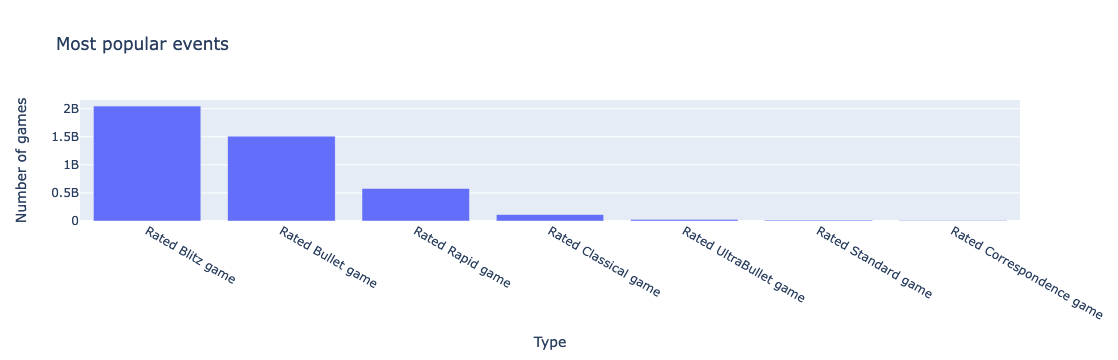

In [23]:
fig = px.bar(event_types_frequencies.head(7), title="Most popular events")
fig.update_xaxes(title_text="Type")
fig.update_yaxes(title_text="Number of games")
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
rated_blitz_time_control_frequencies = data[data["Event"] == "Rated Blitz game"]["TimeControl"].value_counts().compute()
rated_blitz_time_control_frequencies.head(10)

In [ ]:
fig = px.bar(rated_blitz_time_control_frequencies.head(7), title="Rate Blitz time controls")
fig.update_xaxes(title_text="Time control")
fig.update_yaxes(title_text="Number of games")
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
rated_blitz_white_elos = data[data["Event"] == "Rated Blitz game"]["WhiteElo"]
rated_blitz_white_elos[rated_blitz_white_elos > 0].describe().compute()